In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle

HOUSING_PATH = os.path.join("datasets")
pickle_filename = os.path.join(HOUSING_PATH, "lasso_data.pickle")


In [9]:
def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f
 
def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f


In [10]:
def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)
  
    all_basis_fns = [step_fn_generator(stepLoc=s) for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)
 
    def featurize(x):
        n = len(x)
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs
    return target_fn, coefs_true, featurize


In [11]:
def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

In [12]:
def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],data["x_test"], data["y_test"])


In [14]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(pickle_filename)

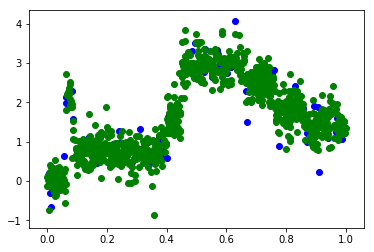

In [17]:
%matplotlib inline
# only in a Jupyter notebook
import matplotlib.pyplot as plt

plt.scatter(x_train, y_train, facecolor='blue')
plt.scatter(x_val, y_val, facecolor='green')
plt.show()

In [18]:
X_train = featurize(x_train)
X_val = featurize(x_val)

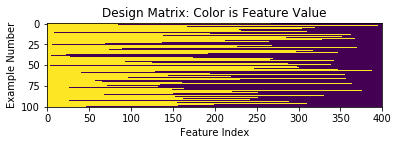

In [19]:
fig, ax = plt.subplots()
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)


In [45]:
def lasso_with_sklearn(X_train, y_train, l1_reg=1):
    from sklearn.linear_model import Lasso
    n = X_train.shape[0]
    sklearn_lasso = Lasso(alpha=n*l1_reg, fit_intercept=False, normalize=False)
    sklearn_lasso.fit(X_train, y_train)
    return sklearn_lasso


In [46]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig


### target function 

In [97]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })


### sklearn lasso prediction function

In [98]:
X = featurize(x)
sklearn_lasso = lasso_with_sklearn(X_train, y_train, 0.00075)
pred_fns.append({"name":"sklearn lasso", "coefs":sklearn_lasso.coef_, "preds": sklearn_lasso.predict(X) })


/home/edvard/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


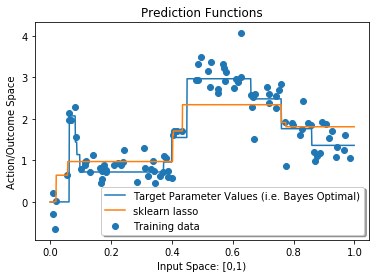

In [99]:
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()
plt.show()